# Vineyard
Experimenting with weighted vineyard distance formulations. Longer line length -> consistent feature -> lower D. Low distance to the diagonal -> unimportant -> lower distance.

In [ ]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go

import multiprocess as mp

import gudhi
import gudhi.wasserstein
import gudhi.hera
import ot

In [4]:
INT_MAX = 2147483647

def persistence(array, fmax=255., inf=INT_MAX, dimension=None, invert=True):
    height, width = array.shape
    cubeComplex = gudhi.CubicalComplex(
        dimensions = [width,height],
        top_dimensional_cells = fmax - array.flatten() if invert else array.flatten()
    )
 
    if dimension == None:
        persistence = cubeComplex.persistence()
    else:
        cubeComplex.compute_persistence()
        persistence = cubeComplex.persistence_intervals_in_dimension(dimension)
        persistence[np.isinf(persistence)] = inf
        
    return persistence

def stitch(PDs, ts):
    vines = [[0, None, [x,]] for x in range(len(PDs[0]))]
    ends = {x:x for x in range(len(PDs[0]))}
    
    for i in range(1, len(ts)):
        dist, match = gudhi.hera.wasserstein_distance(PDs[i-1], PDs[i], matching=True)
    
        baby = []
        # print("IIII", i)
    
        new_ends = {k:ends[k] for k in ends}
        for j, (x, y) in enumerate(match):
            # print(x,y)
            if x == -1:
                baby.append(j)
            elif y == -1: # end vines
                vines[ends[x]][1] = i
                vines[ends[x]][2].append(-1)
                # print(f"end {x} -> -1")
            else: # update vines
                vines[ends[x]][2].append(y)
                new_ends[y] = ends[x]
                # print(f"join {x} -> {y} (ind {ends[x]})")
        
        # new vines
        for j in baby:
            x, y = match[j]
            new_ends[y] = len(vines)
            vines.append([i, None, [y,]])
            # print(f"new {y} -> *")
    
        for k in [l for l in ends]: 
            if k >= len(PDs[i]):
                del new_ends[k]
    
        ends = new_ends

    return vines

def vineyard(f, g, nt=100, dim=0, fmax=255, inf=INT_MAX, verbose=False):
    ts = np.linspace(0, 1, nt)
    hs = np.array([t*f+(1-t)*g for t in ts]) 
    PD0 = [persistence(h, dimension=dim, fmax=fmax, inf=inf) for h in hs]
    vines = stitch(PD0, ts)

    poss = vines
    
    for i,_ in enumerate(vines):
        # print("II", i, vines[i])
        # print(i, vines[i][2], PD0[0][])
        repl = []
        for j,x in enumerate(vines[i][2]):
            if x == -1:
                # print(PD0[vines[i][0]+j-1][vines[i][2][j-1]], "xx")
                repl.append(np.mean(PD0[vines[i][0]+j-1][vines[i][2][j-1]])*np.ones((2,))) # proj prev
            else:
                repl.append(PD0[vines[i][0]+j][x])
    
        poss[i][2] = np.array(repl)
    
    res = [[[ts[p[0]+np.arange(len(p[2]))][i], *x] for i,x in enumerate(p[2])] for p in poss]

    mxs = [np.max(p[2]) for p in poss if np.inf not in p[2]]
    mx = np.max(mxs) if len(mxs) > 0 else INT_MAX

    if verbose:
        fig, axs = plt.subplots(2, 5, figsize=(20, 8))
       
        inds = [0, round(len(ts)*0.4), round(len(ts)/2), round(len(ts)*0.6), -1]
        for ax_idx, i in enumerate(inds):
            axs[0, ax_idx].imshow(hs[i])
            axs[0, ax_idx].set_xticks([])
            axs[0, ax_idx].set_yticks([])
            gudhi.plot_persistence_diagram(PD0[i], axes=axs[1, ax_idx], legend=False)
        plt.tight_layout()
        plt.show()
        
        gos = []
        
        for vine in res:
            vine = np.minimum(np.array(vine), INT_MAX) # INTMAX for INF
            gos.append(go.Scatter3d(x=vine[:,0], y=vine[:,1], z=vine[:,2], marker=dict(
                size=2,
            ),
            line=dict(
                width=2
            )))
        
        xs = np.linspace(0, mx, 10)
        zs = np.linspace(0, 1, 10)
        xss, zss = np.meshgrid(xs, zs)
        gos.append(go.Surface(x=zss, y=xss, z=xss, colorscale=[[0, '#333'], [1, '#333']], opacity=0.1, showscale=False)) # x - y = 0: diag plane
        
        fig = go.Figure(data=gos)
        
        fig.update_layout(
            width=800,
            height=700,
            scene=dict(
              xaxis_title='T (homotopy)',
            zaxis=dict(range=[0,mx], title="Death"),
            yaxis=dict(range=[0,mx], title="Birth")
          ),

        )
        
        fig.show()

    return res

def vdist(vines, fD=lambda _:1, fL=lambda _:1): # diag weight func, length weight func
    V = 0

    for i in range(len(vines)):
        vines[i] = np.minimum(np.array(vines[i]), INT_MAX)

    for vine in vines:    
        v, L = 0, 0
        for i in range(1, len(vine)):
            l = np.linalg.norm(vine[i][1:]-vine[i-1][1:], ord=np.inf)
            dt = vine[i][0] - vine[i-1][0]
    
            mid = vine[i-1][1:] # first pt ~ mid pt in
            proj = np.mean(mid)*np.ones(2,) # Euclidean projection onto diagonal
            D = np.linalg.norm(proj-mid) # Euclidean dist to diagonal
            w = fD(D)
           
            ds = l*dt 
            v += w*ds
            L += ds
    
        v *= fL(L)
        V += v


    return V

In [5]:
def gauss(c, sigma, shape):
    f = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            f[i][j] = np.exp(-(np.linalg.norm(np.array([i, j])-np.array(c))/sigma)**2)

    return f

In [6]:
def stretch01(f):
    return (f - np.min(f)) / (np.max(f) - np.min(f))

In [129]:
np.random.seed(0)

dim = 1
B = 1
S = 100
method = ['mu', 'sigma'][0]
xs = np.linspace(0, S/2, 40)
if method == 'mu':
    xs = xs[:-1]
else:
    xs = xs[1:]
noise = 0.
res = []

for b in range(B):
    print(b)
    fr = np.random.rand(S,S)*noise
    gr = np.random.rand(S,S)*noise
    f = gauss((S/2,S/2), 5, (S,S)) + fr
    f = stretch01(f)
    if dim == 1:
        f = 1-f

    def sim(x, verbose=0):
        if method == 'mu':
            g = gauss((S/2+x,S/2), 5, (S,S)) + gr
        else:
            g = gauss((S/2, S/2), x, (S,S))
        
        g = stretch01(g)
        if dim == 1:
            g = 1-g
        vines = vineyard(f, g, nt=100, dim=dim, fmax=1, inf=np.inf, verbose=False)
        d = vdist(vines, lambda D: D, lambda L: 1)
        pdF = persistence(f, dimension=dim, fmax=1, inf=np.inf)
        pdG = persistence(g, dimension=dim, fmax=1, inf=np.inf)
        
        if verbose > 0:
            fig, axes = plt.subplots(2, 2, figsize=(5, 5))
            gudhi.plot_persistence_diagram(pdF, axes=axes[0,1], legend=False, fontsize=8)
            gudhi.plot_persistence_diagram(pdG, axes=axes[1,1], legend=False, fontsize=8)
            # ticks = [5, 15, 25, 35]
            pw = 5  
            fp = np.pad(f, pad_width=pw, mode='constant', constant_values=0)
            gp = np.pad(g, pad_width=pw, mode='constant', constant_values=0)
            ticks = np.arange(0, S, 5)+pw
            labels = [str(t-pw) for t in ticks]
            axes[0,0].imshow(fp)
            axes[0, 0].set_xticks(ticks)
            axes[0, 0].set_xticklabels(labels, fontsize=6)
            axes[0, 0].set_yticks(ticks)
            axes[0, 0].set_yticklabels(labels, fontsize=6)
            axes[1,0].imshow(gp)
            axes[1, 0].set_xticks(ticks)
            axes[1, 0].set_xticklabels(labels, fontsize=6)
            axes[1, 0].set_yticks(ticks)
            axes[1, 0].set_yticklabels(labels, fontsize=6)
            plt.tight_layout()
            plt.show()
        wd = gudhi.hera.wasserstein_distance(pdF, pdG)
        dl1 = np.sum(np.abs(f-g))
        dl2 = np.sqrt(np.sum((f-g)**2))
        return d, wd, dl1, dl2

    with mp.Pool() as pool:
        results = pool.map(sim, xs)
        res.append(results)


0


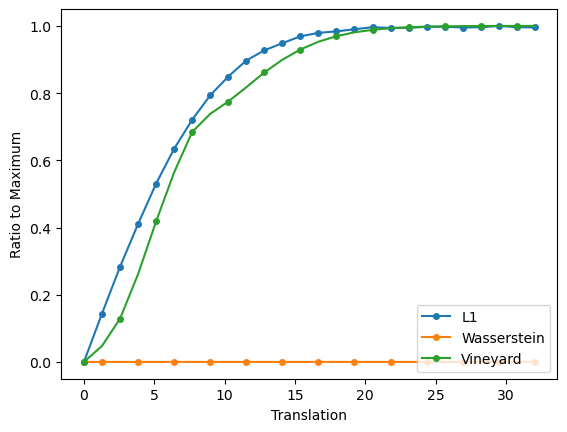

In [130]:
res = np.array(res)
avgs = np.mean(res, axis=0)
maxes = np.tile(np.max(avgs, axis=0), (avgs.shape[0],1))
ratios = np.where(maxes == 0, avgs, avgs / maxes)

b = len(xs)*2//3
# b = len(xs)
plt.plot(xs[:b], ratios[:b,2], '-o', markersize=4, label="L1", color='tab:blue')
plt.plot(xs[:b], ratios[:b,1], '-o', markersize=4, label="Wasserstein", color='tab:orange', markevery=(1,2))
plt.plot(xs[:b], ratios[:b,0], '-o', markersize=4, label="Vineyard", color='tab:green', markevery=2)
# plt.plot(xs, ratios[:,3], '-o', markersize=4, label="L2")
plt.xlabel("Variance" if method == 'sigma' else "Translation")
plt.ylabel("Ratio to Maximum")
# plt.title("Vineyard vs. Wasserstein (Gaussian)")
plt.legend(loc='lower right')
plt.show()